# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as nd
import glob
import shutil

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
image = nib.load('/data/TrainingSet/images/hippocampus_001.nii.gz')
label = nib.load('/data/TrainingSet/labels/hippocampus_001.nii.gz')

In [3]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

image_array = image.get_fdata()
label_array = label.get_fdata()

image_array.shape, label_array.shape

((35, 51, 35), (35, 51, 35))

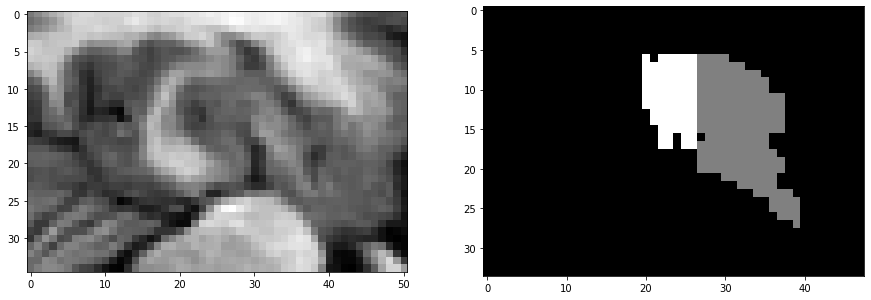

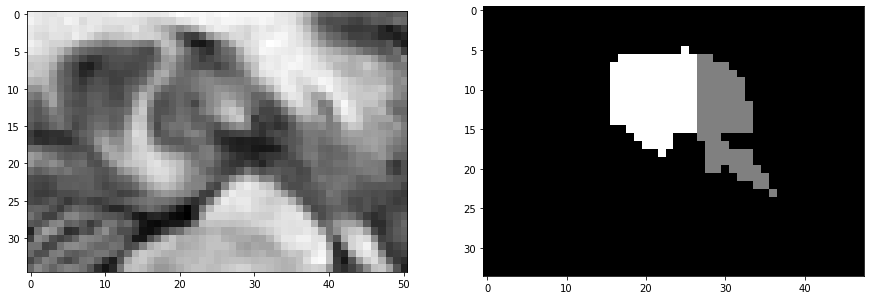

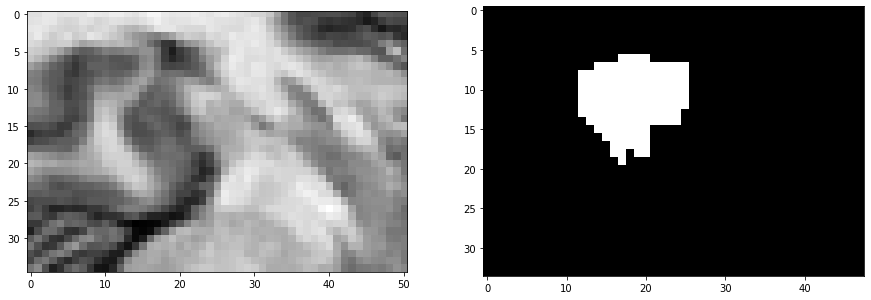

In [7]:
plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(1,2,1)
plt.imshow(image_array[:,:,15], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[:,:,15], cmap='gray')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[:,:,17], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[:,:,17], cmap='gray')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[:,:,19], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[:,:,19], cmap='gray');

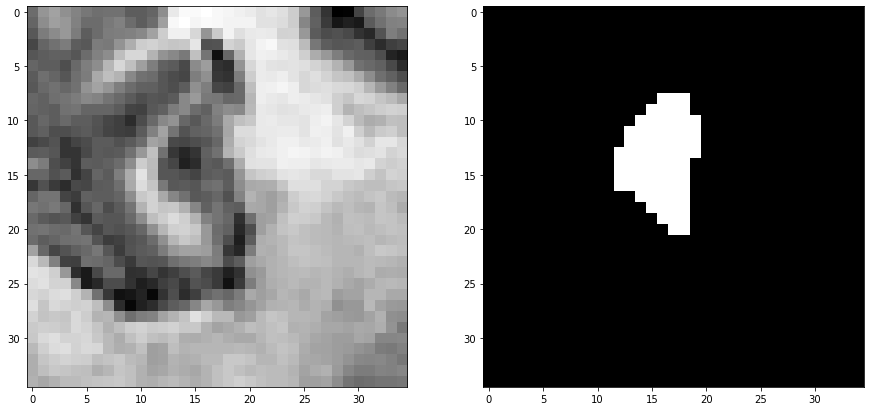

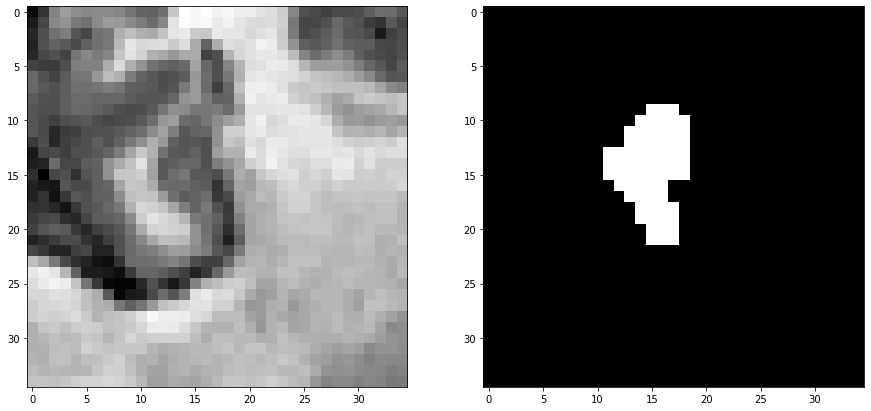

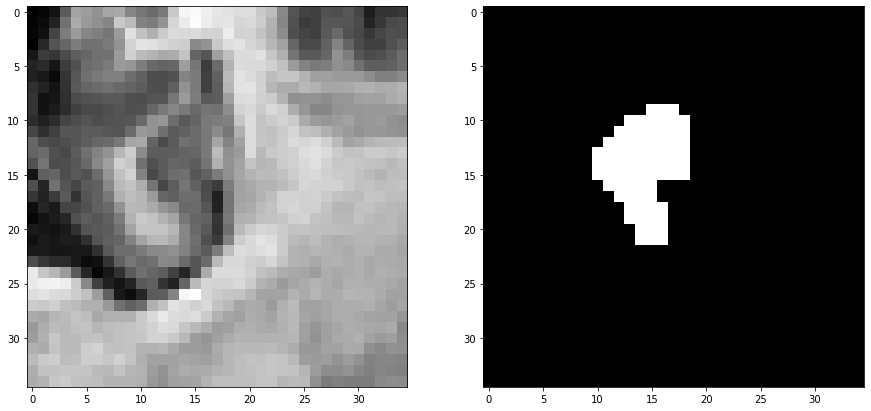

In [20]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[:,23,], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[:,23,], cmap='gray')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[:,25,], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[:,25,], cmap='gray')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[:,27,], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[:,27,], cmap='gray');

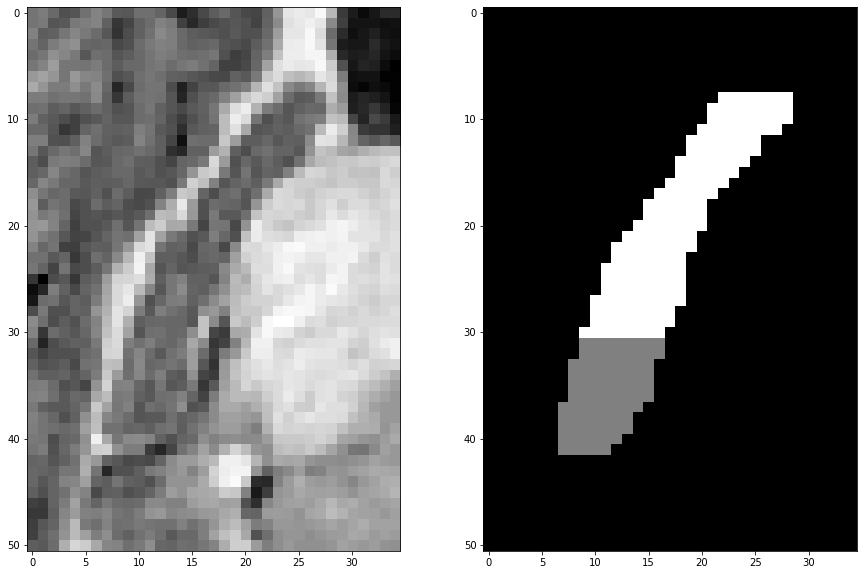

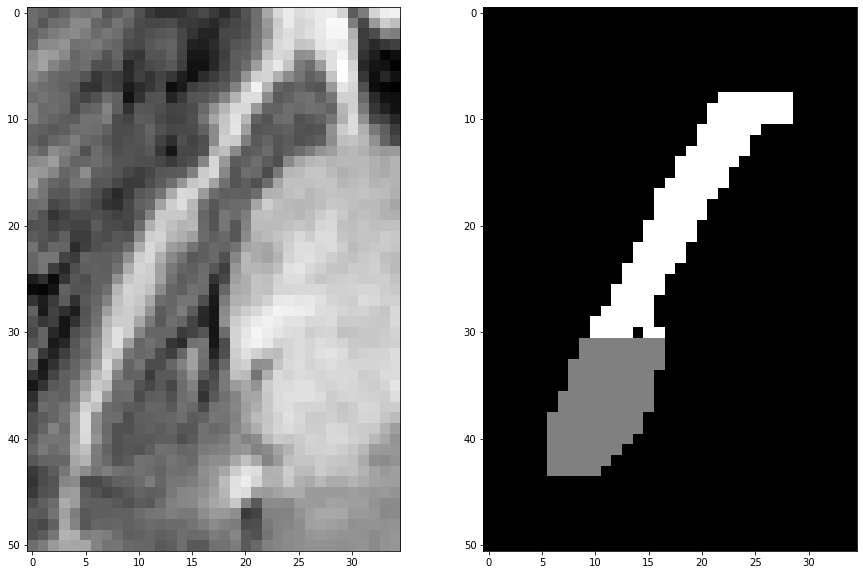

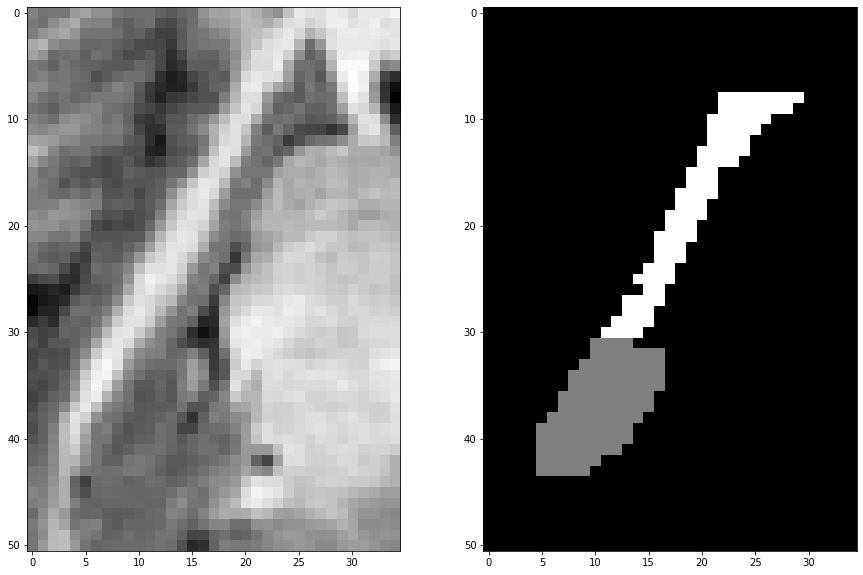

In [21]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[15,:,:], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[15,:,:], cmap='gray')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[17,:,:], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[17,:,:], cmap='gray')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[19,:,:], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label_array[19,:,:], cmap='gray');

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

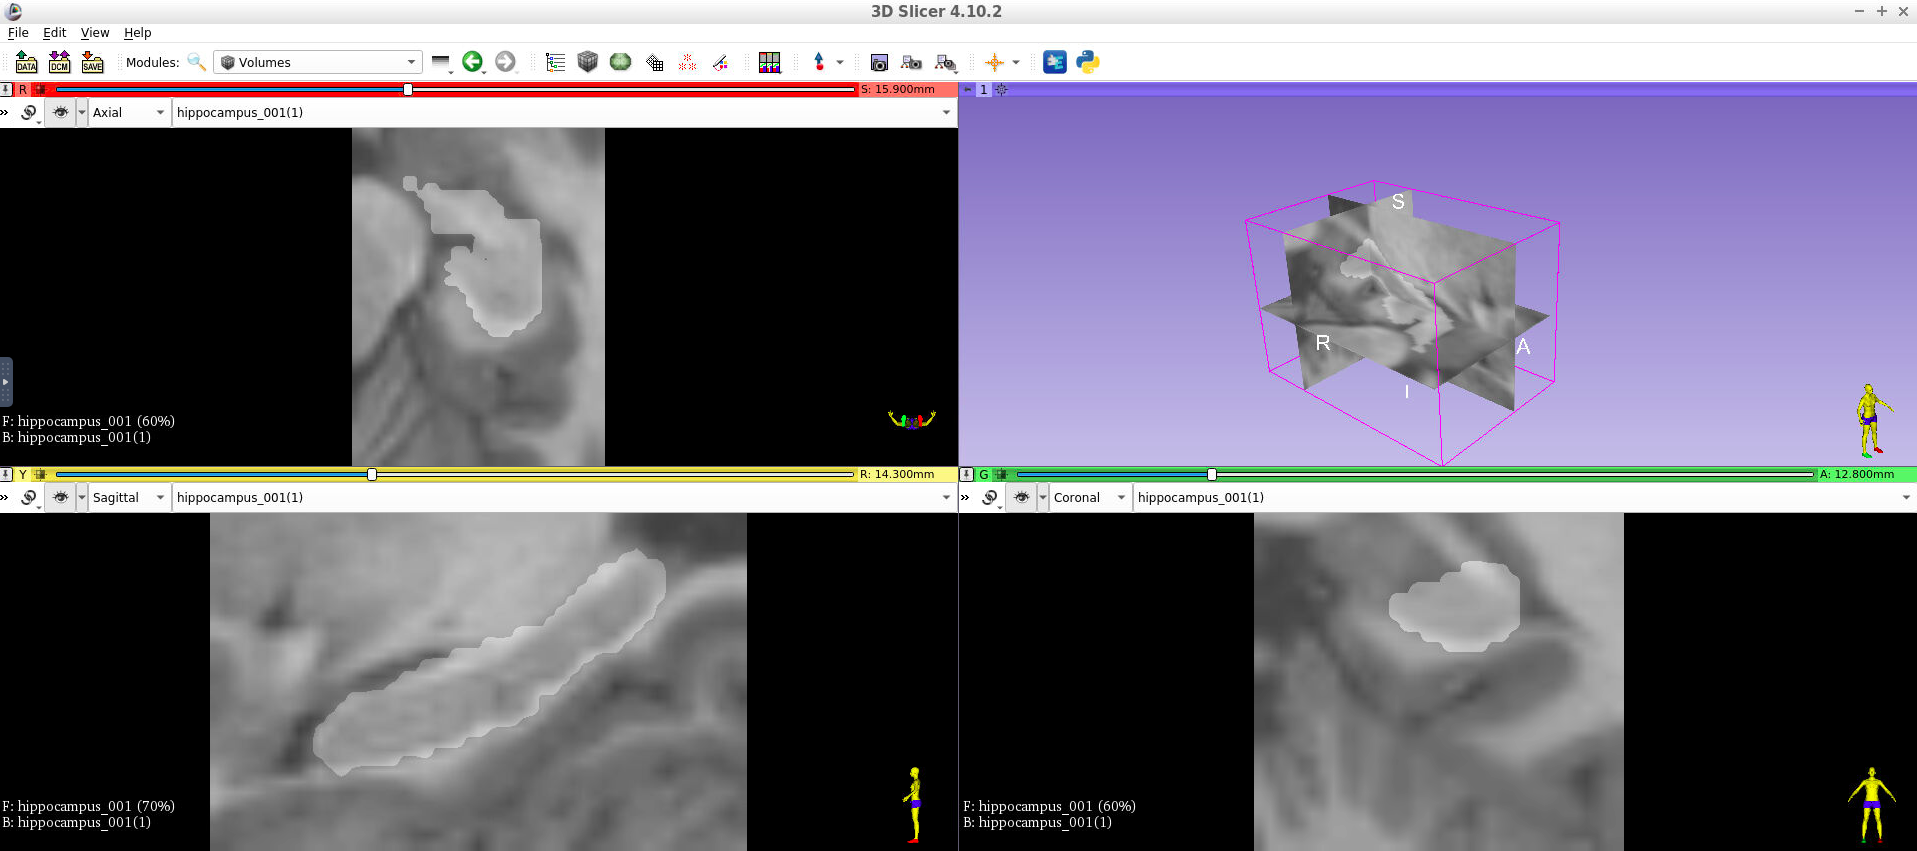

In [23]:
Image.open('3D-Slicer-Screenshot.png')

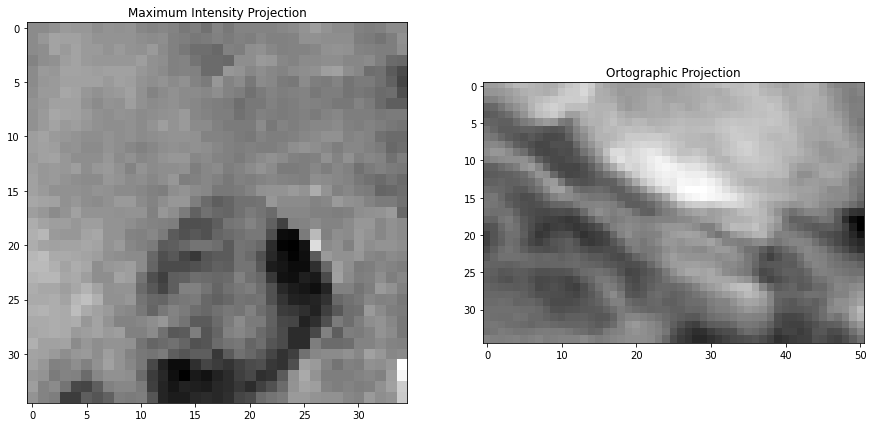

In [10]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes

orto = np.zeros((image_array.shape[1], image_array.shape[2]))
for y in range(image_array.shape[1]):
    for z in range(image_array.shape[2]):

        orto[y,z] = np.sum(image_array[:,y,z], axis=0)
        
maxint = np.zeros((image_array.shape[0], image_array.shape[2]))
for x in range(image_array.shape[0]):
    for z in range(image_array.shape[2]):

        maxint[x,z] = np.max(image_array[x,:,z], axis=0)
    
plt.subplot(121)
plt.imshow(nd.rotate(maxint, 90), cmap='gray')
plt.title('Maximum Intensity Projection')
plt.subplot(122)
plt.imshow(nd.rotate(orto, 90), cmap='gray')
plt.title('Ortographic Projection');

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [12]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

image.header_class, label.header_class

(nibabel.nifti1.Nifti1Header, nibabel.nifti1.Nifti1Header)

Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [26]:
# TASK: How many bits per pixel are used?
image.header['bitpix']

array(8, dtype=int16)

In [32]:
# TASK: What are the units of measurement?
image.header['xyzt_units'] # -> mm

array(10, dtype=uint8)

10 is 2 in binary system and that codes milimeters.

In [4]:
# TASK: Do we have a regular grid? What are grid spacings?
image.header['pixdim']

array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

Ones indicates that the grid is regular.

In [ ]:
#TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?

In [5]:
image.header['dim']

array([ 3, 35, 51, 35,  1,  1,  1,  1], dtype=int16)

Judging from image shape, above visualisation and visualisation in 3D Slicer:

- first dimension (35) is Sagittal

- second dimension (51) is coronal

- third dimension (35) is axial

In [39]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500

hippo_volume = np.sum(label_array > 0)
    
print('Hippocampus volume: ', hippo_volume, ' mm³')

Hippocampus volume:  2948  mm³


In [21]:
np.unique(label_array)

array([0., 1., 2.])

## Plotting some charts

In [ ]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.

In [4]:
all_labels = glob.glob('/data/TrainingSet/labels/*.nii.gz')
len(all_labels), all_labels[0]

(262, '/data/TrainingSet/labels/hippocampus_376.nii.gz')

In [13]:
volumes = []
for label_path in all_labels:
    label_array = nib.load(label_path).get_fdata()
    
    volumes.append(np.sum(label_array > 0))
    
len(volumes)

262

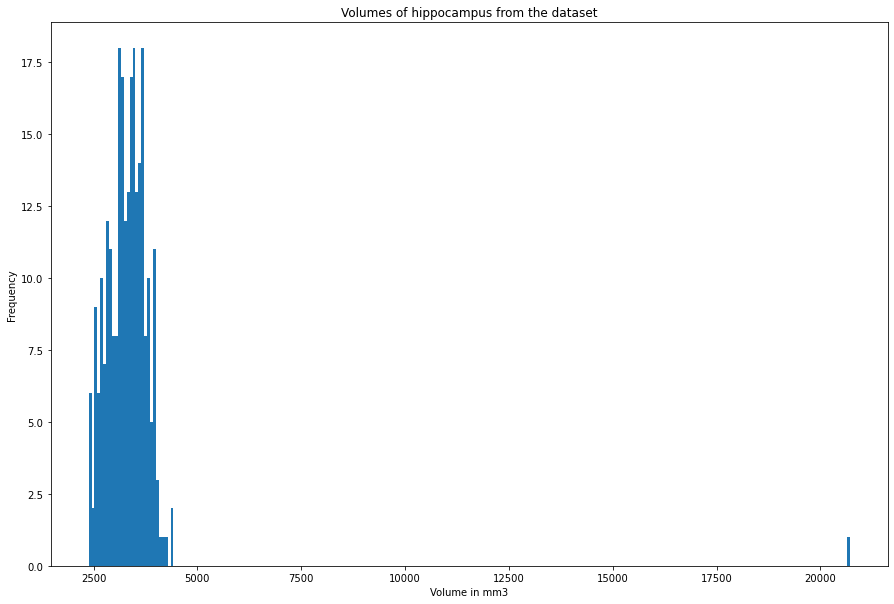

In [14]:
plt.hist(volumes, bins=260)
plt.title('Volumes of hippocampus from the dataset')
plt.xlabel('Volume in mm3')
plt.ylabel('Frequency');

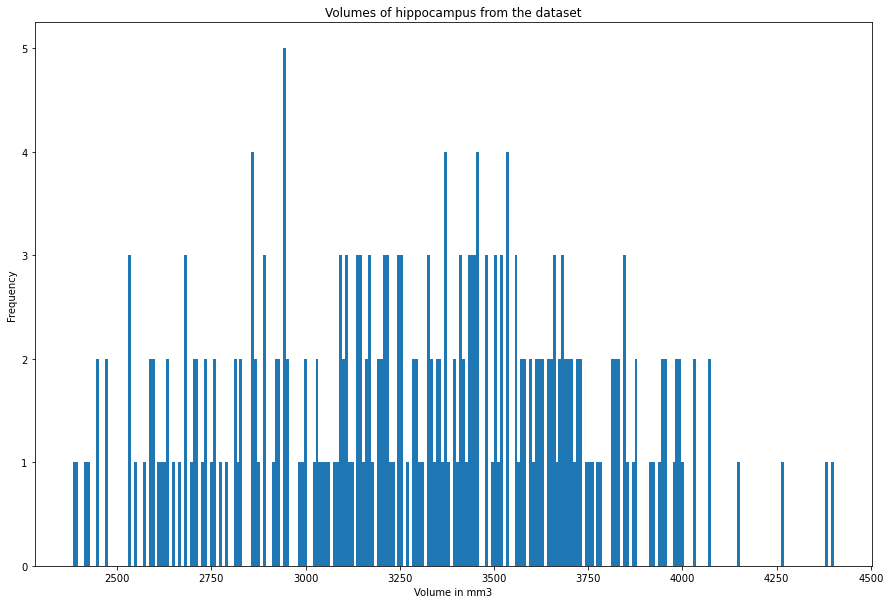

In [16]:
volumes.remove(max(volumes))
plt.hist(volumes, bins=260)
plt.title('Volumes of hippocampus from the dataset')
plt.xlabel('Volume in mm3')
plt.ylabel('Frequency');

### Outliers

Big hippocampus:

In [66]:
np.where(np.asarray(volumes) > 4700)

(array([200]),)

In [47]:
big_hippo = nib.load(all_labels[200]).get_fdata()
big_hippo.shape

(512, 512, 94)

In [48]:
all_labels[200]

'/data/TrainingSet/labels/hippocampus_281.nii.gz'

(512, 512, 31)

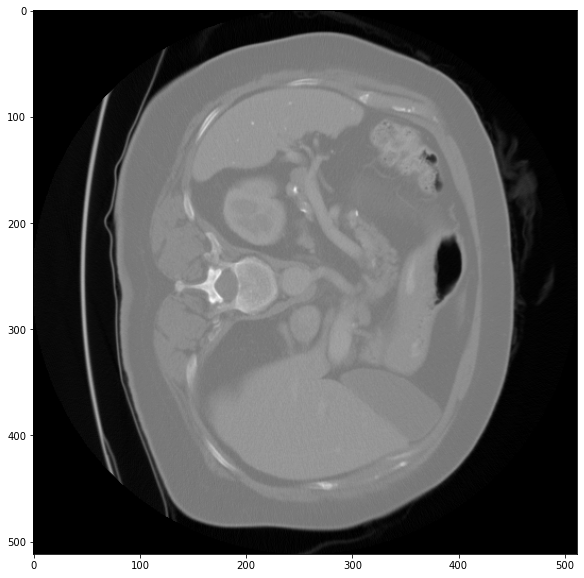

In [59]:
big_hippo_img = nib.load('/data/TrainingSet/images/hippocampus_281.nii.gz').get_fdata()
plt.imshow(big_hippo_img[:,:,15], cmap='gray')
big_hippo_img.shape

Check if every image has label and vice versa:

In [12]:
all_imgs = glob.glob('/data/TrainingSet/images/*.nii.gz')
len(all_imgs), all_imgs[0]

(263, '/data/TrainingSet/images/hippocampus_376.nii.gz')

In [96]:
all_labels_2 = [label.split('/')[-1] for label in all_labels]
all_imgs_2 = [img.split('/')[-1] for img in all_imgs]

In [97]:
len(all_labels_2), len(all_imgs_2)

(262, 263)

In [98]:
for label in all_labels_2:
    if label not in all_imgs_2:
        print(label)

In [99]:
for img in all_imgs_2:
    if img not in all_labels_2:
        print(img)

hippocampus_118.nii.gz


Look for outliers based on pixdim and dim:

In [122]:
for img in all_imgs:
    image = nib.load(img)
    if image.header['pixdim'][0] != 1 or image.header['dim'][1] > 100:
        print(all_imgs.index(img), image.header['pixdim'], image.header['dim'])

201 [1.       0.785156 0.785156 7.5      0.       0.       0.       0.      ] [  3 512 512  31   1   1   1   1]
241 [-1.        0.597656  0.597656  1.25      0.        0.        0.
  0.      ] [  3 512 512 241   1   1   1   1]


The first one of these two is the same as above - the one with big 'hippocampus':

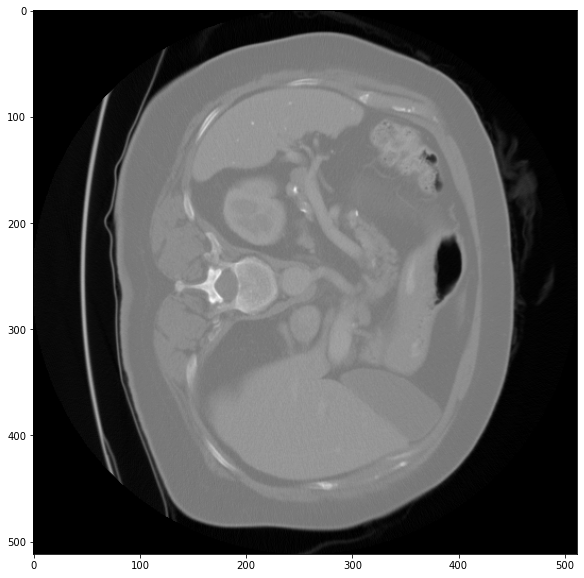

In [128]:
plt.imshow(nib.load(all_imgs[201]).get_fdata()[:,:,15], cmap='gray');

And there is another CT chest and abdomen scan:

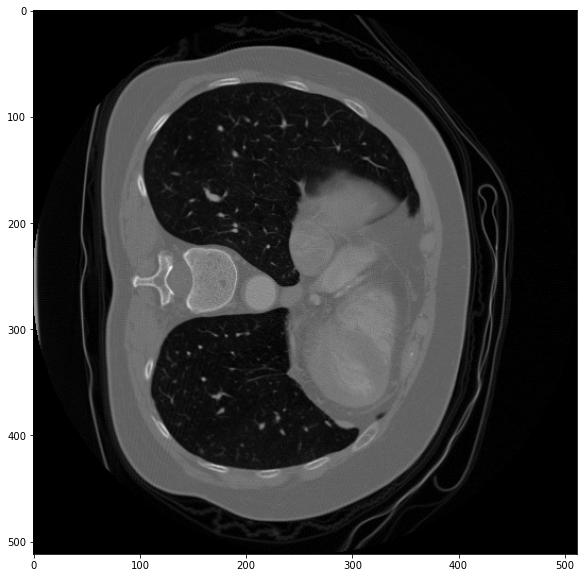

In [150]:
plt.imshow(nib.load(all_imgs[241]).get_fdata()[:,:,75], cmap='gray');

In [131]:
all_imgs[241]

'/data/TrainingSet/images/hippocampus_010.nii.gz'

(36, 50, 31)

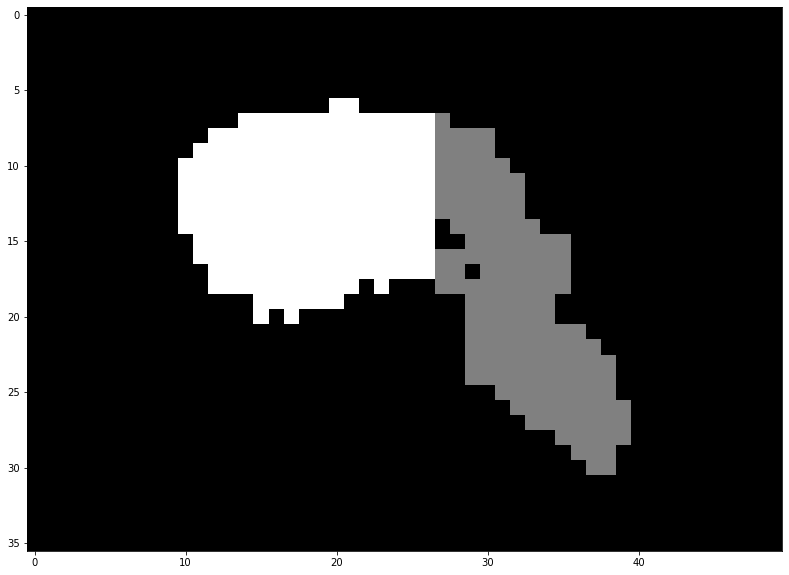

In [132]:
outlier = nib.load('/data/TrainingSet/labels/hippocampus_010.nii.gz').get_fdata()
plt.imshow(outlier[:,:,15], cmap='gray')
outlier.shape

It seems that the second CT scan has its hippocampus label which was a little bit tricky, because at first I was looking for outliers based on labels only.

### Small hippocampus

In [62]:
np.where(np.asarray(volumes) < 2700)

(array([ 11,  22,  35,  44,  52,  96, 124, 129, 131, 135, 149, 152, 154,
        157, 166, 178, 187, 194, 209, 214, 215, 222, 228, 234, 242, 249,
        254, 257]),)

In [54]:
min(volumes), volumes.index(min(volumes))

(2382, 35)

0 percentile -> this hippocampus and other very small ones may come from patients with disease

In [55]:
small_hippo = nib.load(all_labels[35]).get_fdata()
small_hippo.shape

(34, 50, 32)

In [56]:
all_labels[35]

'/data/TrainingSet/labels/hippocampus_279.nii.gz'

(34, 50, 32)

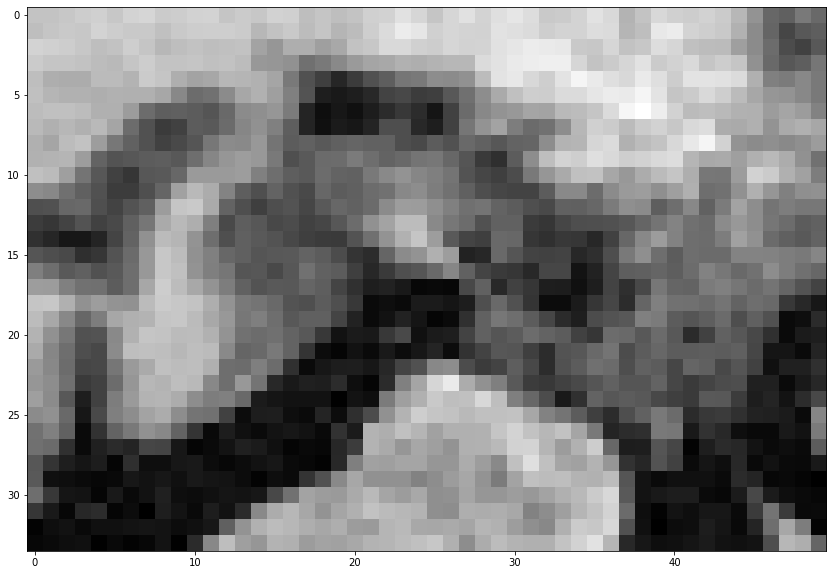

In [58]:
big_hippo_img = nib.load('/data/TrainingSet/images/hippocampus_279.nii.gz').get_fdata()
plt.imshow(big_hippo_img[:,:,15], cmap='gray')
big_hippo_img.shape

<img src="img/nomogram_fem_right.svg" width=400 align=left>

Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [16]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section
labels_black_list = ['/data/TrainingSet/labels/hippocampus_010.nii.gz',
                     '/data/TrainingSet/labels/hippocampus_281.nii.gz']

images_black_list = ['/data/TrainingSet/images/hippocampus_010.nii.gz',
                     '/data/TrainingSet/images/hippocampus_118.nii.gz',
                     '/data/TrainingSet/images/hippocampus_281.nii.gz']

for img in all_imgs:
    if img not in images_black_list:
        shutil.copyfile(img, '/home/workspace/out/images/' + img.split('/')[-1])
    
for label in all_labels:
    if label not in labels_black_list:
        shutil.copyfile(label, '/home/workspace/out/labels/' + label.split('/')[-1])

## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!